In [50]:
import sim_utils
import pickle

import numpy as np
import matplotlib.pyplot as plt

In [65]:
def load_results(filename: str) -> [sim_utils.Trajectory]:
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
def get_3sigma_spread(data):
    sd = np.std(data)
    mu = np.mean(data)
    
    within_3sigma = np.abs(data - mu) < 3*sd
    return data[within_3sigma]

def get_footprint(S_list):
    """Returns footprint size for given downrange spread"""
    return np.abs(np.max(S_list) - np.min(S_list))

In [52]:
def postprocess(monte_carlo_results: [sim_utils.Trajectory]) -> dict:
    """
    Post-process Monte-Carlo simulation data to calculate relevant data
    
    Returns a dictionary
    """

    qf_vec = []
    hf_vec = []
    s_vec = []
    peakG_vec = []
    S_list = []
    for traj in monte_carlo_results:
        X = traj.X
        params = traj.params
        u = traj.u
        
        S_list.append(traj.X[-1,1])
        
        h, s, v, gam = traj.X.T   # separate out the columns
        
        rho0 = params['rho0']
        beta = params['beta']
        H = params['H']
        LD = params['LD']
        
        rho = rho0 * np.exp(-h/H)
        q = rho * v * v / 2     # Dynamic pressure
        D_m = q / beta          # Drag Acceleration (D/m)

        L_m = LD * D_m * np.cos(u) # Lift Acceleration (L/m)
        G = np.sqrt(D_m ** 2 + L_m ** 2)/9.81
        peak_G = max(G)
        
        qf_vec.append(q[-1])       # Dynamic pressure at chute deploy
        hf_vec.append(h[-1])       # Altitude at chute deploy
        s_vec.append(s[-1])        # Downrange distance
        peakG_vec.append(peak_G)

    S_footprint = get_footprint(S_list)
    return {'qf': np.array(qf_vec),
            'hf': np.array(hf_vec),
            's': np.array(s_vec),
            'peak_G': np.array(peakG_vec),
            'S_footprint': S_footprint,
            'S_list': np.array(S_list),
           }

In [53]:
def plot_downrange_spread(data, title):
    plt.hist(data['s']/1e3)
    plt.xlabel('Downrange distance [km]')
    plt.ylabel('Number of instances')
    plt.title(title)
    plt.show()

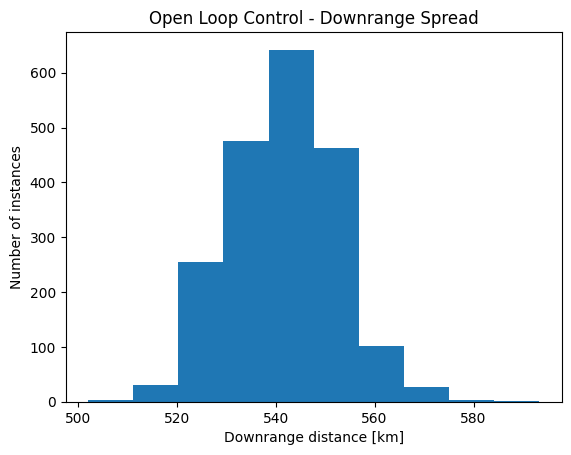

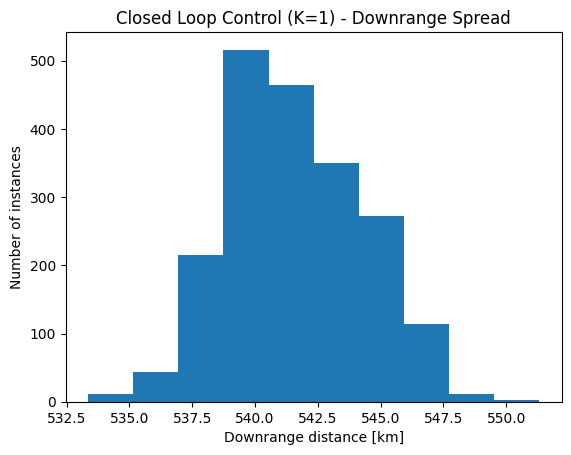

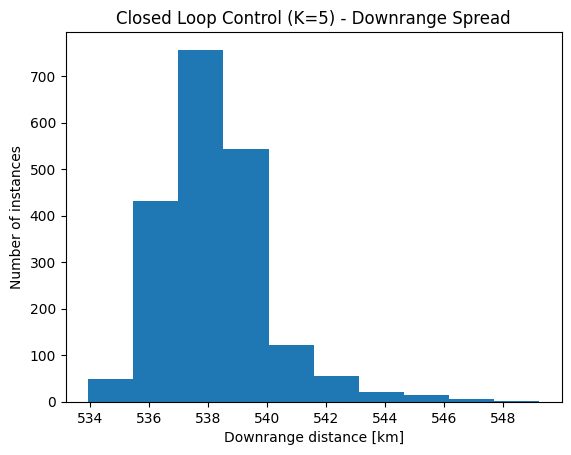

In [54]:
OpenLoop_data = postprocess(load_results('OpenLoop_2000.dat'))
K1_data = postprocess(load_results('K1_2000.dat'))
K5_data = postprocess(load_results('K5_2000.dat'))

plot_downrange_spread(OpenLoop_data, 'Open Loop Control - Downrange Spread')
plot_downrange_spread(K1_data, 'Closed Loop Control (K=1) - Downrange Spread')
plot_downrange_spread(K5_data, 'Closed Loop Control (K=5) - Downrange Spread')

In [67]:
print('Openloop footprint: ', OpenLoop_data['S_footprint']/1e3, 'km')
print('Closed loop footprint (K = 1): ', K1_data['S_footprint']/1e3, 'km')
print('Closed loop footprint (K = 5): ', K5_data['S_footprint']/1e3, 'km')

O_99_sd = get_footprint(get_3sigma_spread(OpenLoop_data['S_list']))
K1_99 = get_footprint(get_3sigma_spread(K1_data['S_list']))
K5_99 = get_footprint(get_3sigma_spread(K5_data['S_list']))
print()
print('Openloop footprint 3-sigma: ', O_99/1e3, 'km')
print('Closed loop footprint (K = 1) 3-sigma: ', K1_99/1e3, 'km')
print('Closed loop footprint (K = 5) 3-sigma: ', K5_99/1e3, 'km')

Openloop footprint:  91.09681724171725 km
Closed loop footprint (K = 1):  17.949405768437778 km
Closed loop footprint (K = 5):  15.278329833452124 km

Openloop footprint 3-sigma:  64.76807421214262 km
Closed loop footprint (K = 1) 3-sigma:  15.471591220306815 km
Closed loop footprint (K = 5) 3-sigma:  9.685400003367802 km
